In [48]:
# dense_layer
import numpy as np
from nnfs.datasets import spiral_data

class LayerDense:
    # layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights with small random numbers
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        
        # Initialize biases with zeros
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember inputs for potential backpropagation     
        self.inputs = inputs

        #Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases   

    # Backward pass
    def backward(self, dvalues):
        # Gradient on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)



In [49]:
# Relu activation
class ActivationReLU:
    # Forward pass
    def forward(self, inputs):
        # remember inputs
        self.inputs = inputs
        # calculate output values from inputs
        self.output = np.maximum(0, inputs)
    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0    



In [50]:
# create softmax activation
class ActivationSoftmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

In [51]:
# cross-entropy loss
# Lecture 8 - Coding the cross entropy loss in Python (from scratch)
class Loss_CategoricalCrossentropy:
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    # Lecrure 18 - Implementing backpropagation on the cross entropy loss function
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues) # all one dimensional values in 2 dimensional array
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0]) # lenght of first sample
        
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [52]:
#Softmax classifier - combined Softmax activation and cross-entropy loss
class ActivationSoftmax_LossCategoricalCrossentropy():
    #create activation and loss function objects
    def __init__(self):
        self.activation = ActivationSoftmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        self.loss = Loss_CategoricalCrossentropy()
        return self.loss.forward(self.output, y_true)
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()

        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1 # Lecture 19 - Combined backpropagation on softmax activation and cross entropy loss
        # Normalize gradient
        self.dinputs = self.dinputs / samples

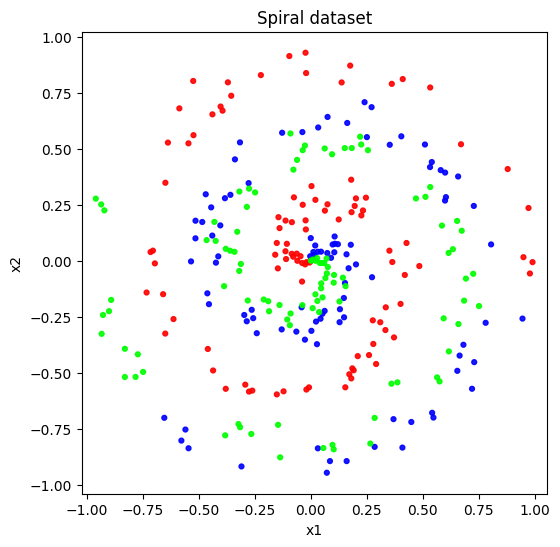

In [53]:
# create dataset
X, y = spiral_data(samples=100, classes=3)
# plot dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=12, alpha=0.9)
plt.title('Spiral dataset')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.show()

In [54]:
# create dataset
X, y = spiral_data(samples=100, classes=3)
# create dense layer with 2 input features and 3 output values
dense1 = LayerDense(2, 3)
# create ReLU activation (to be used with dense layer)
activation1 = ActivationReLU()
# create second dense layer with 3 input features and 3 output values
dense2 = LayerDense(3, 3)
# crate softmax classifier's combined loss and activation
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
# forward pass through first dense layer
dense1.forward(X)
# forward pass through ReLU activation
activation1.forward(dense1.output)
# forward pass through second dense layer
dense2.forward(activation1.output)
# forward pass through softmax activation and loss function
loss = loss_activation.forward(dense2.output, y)

print(loss_activation.output[:5]) # show output of the first 5 samples

#print('losd',loss)

#calculate accuracy
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
print('accuracy:', accuracy)   

# backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)
# print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)



[[0.33333333 0.33333333 0.33333333]
 [0.33333319 0.33333368 0.33333312]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333292 0.33333428 0.33333281]]
accuracy: 0.4033333333333333
[[-2.01163839e-04  2.16246413e-04  4.50703823e-05]
 [ 3.41658802e-04 -2.77444214e-04 -3.85828916e-05]]
[[ 1.28561967e-06 -5.02467961e-04 -3.46366940e-04]]
[[ 1.03644520e-04  2.53397450e-05 -1.28984265e-04]
 [ 8.87598227e-05 -2.45827454e-05 -6.41770773e-05]
 [ 3.47352902e-04 -1.24672186e-04 -2.22680716e-04]]
[[-6.47075031e-07  3.07776293e-06 -2.43068790e-06]]


In [55]:
# Gradient descent optimizer
class OptimizerSGD:
    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate

    # Update parameters
    def update_params(self, layer):
        # Vanilla SGD parameter update
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases 

In [56]:
#create dataset
X, y = spiral_data(samples=100, classes=3)
# create dense layer with 2 input features and 3 output values
dense1 = LayerDense(2, 64)
# create ReLU activation (to be used with dense layer)
activation1 = ActivationReLU()
# create second dense layer with 64 input features and 3 output values
dense2 = LayerDense(64, 3)
# crate softmax classifier's combined loss and activation
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
# create optimizer
optimizer = OptimizerSGD(learning_rate=1.0)

# Train in loop
for epoch in range(10001):
    # Forward pass through first dense layer
    dense1.forward(X)
    # Forward pass through ReLU activation
    activation1.forward(dense1.output)
    # Forward pass through second dense layer
    dense2.forward(activation1.output)
    # Forward pass through softmax activation and loss function
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, ' +
              f'loss: {np.mean(loss):.3f}, ' +
              f'accuracy: {accuracy:.3f}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

Epoch: 0, loss: 1.099, accuracy: 0.413
Epoch: 100, loss: 1.077, accuracy: 0.420
Epoch: 200, loss: 1.070, accuracy: 0.433
Epoch: 300, loss: 1.066, accuracy: 0.443
Epoch: 400, loss: 1.065, accuracy: 0.433
Epoch: 500, loss: 1.063, accuracy: 0.447
Epoch: 600, loss: 1.062, accuracy: 0.457
Epoch: 700, loss: 1.062, accuracy: 0.460
Epoch: 800, loss: 1.061, accuracy: 0.470
Epoch: 900, loss: 1.060, accuracy: 0.470
Epoch: 1000, loss: 1.057, accuracy: 0.470
Epoch: 1100, loss: 1.052, accuracy: 0.473
Epoch: 1200, loss: 1.046, accuracy: 0.490
Epoch: 1300, loss: 1.039, accuracy: 0.483
Epoch: 1400, loss: 1.045, accuracy: 0.433
Epoch: 1500, loss: 1.051, accuracy: 0.420
Epoch: 1600, loss: 1.049, accuracy: 0.417
Epoch: 1700, loss: 1.041, accuracy: 0.420
Epoch: 1800, loss: 1.034, accuracy: 0.443
Epoch: 1900, loss: 1.039, accuracy: 0.453
Epoch: 2000, loss: 1.035, accuracy: 0.437
Epoch: 2100, loss: 1.034, accuracy: 0.473
Epoch: 2200, loss: 1.031, accuracy: 0.440
Epoch: 2300, loss: 1.029, accuracy: 0.473
Epoc

In [57]:
class Optimizer_SGD:
   #init method with learning rate and decay
   def __init__(self, learning_rate=1.0, decay=0.0):
       self.learning_rate = learning_rate
       self.current_learning_rate = learning_rate
       self.decay = decay
       self.iterations = 0  
    #pre -update learning rate
   def pre_update_params(self):
       if self.decay:
           self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    #update parameters
   def update_params(self, layer):
       # Vanilla SGD parameter update
       layer.weights += -self.current_learning_rate * layer.dweights
       layer.biases += -self.current_learning_rate * layer.dbiases 
    #post-update method
   def post_update_params(self):
       self.iterations += 1   
    

In [58]:
#create dataset
X, y = spiral_data(samples=100, classes=3)
# create dense layer with 2 input features and 3 output values
dense1 = LayerDense(2, 64)
# create ReLU activation (to be used with dense layer)
activation1 = ActivationReLU()
# create second dense layer with 64 input features and 3 output values
dense2 = LayerDense(64, 3)
# crate softmax classifier's combined loss and activation
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
# create optimizer
optimizer = Optimizer_SGD(decay=1e-3)

# Train in loop
for epoch in range(10001): 
    # Forward pass through first dense layer
    dense1.forward(X)
    # Forward pass through ReLU activation
    activation1.forward(dense1.output)
    # Forward pass through second dense layer
    dense2.forward(activation1.output)
    # Forward pass through softmax activation and loss function
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, ' +
              f'loss: {np.mean(loss):.3f}, ' +
              f'accuracy: {accuracy:.3f}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

Epoch: 0, loss: 1.099, accuracy: 0.340
Epoch: 100, loss: 1.085, accuracy: 0.423
Epoch: 200, loss: 1.074, accuracy: 0.423
Epoch: 300, loss: 1.072, accuracy: 0.410
Epoch: 400, loss: 1.071, accuracy: 0.413
Epoch: 500, loss: 1.070, accuracy: 0.427
Epoch: 600, loss: 1.069, accuracy: 0.413
Epoch: 700, loss: 1.067, accuracy: 0.413
Epoch: 800, loss: 1.066, accuracy: 0.407
Epoch: 900, loss: 1.064, accuracy: 0.407
Epoch: 1000, loss: 1.063, accuracy: 0.403
Epoch: 1100, loss: 1.061, accuracy: 0.410
Epoch: 1200, loss: 1.058, accuracy: 0.420
Epoch: 1300, loss: 1.056, accuracy: 0.427
Epoch: 1400, loss: 1.054, accuracy: 0.430
Epoch: 1500, loss: 1.051, accuracy: 0.430
Epoch: 1600, loss: 1.048, accuracy: 0.443
Epoch: 1700, loss: 1.045, accuracy: 0.450
Epoch: 1800, loss: 1.042, accuracy: 0.457
Epoch: 1900, loss: 1.038, accuracy: 0.457
Epoch: 2000, loss: 1.035, accuracy: 0.460
Epoch: 2100, loss: 1.032, accuracy: 0.463
Epoch: 2200, loss: 1.029, accuracy: 0.467
Epoch: 2300, loss: 1.025, accuracy: 0.473
Epoc

In [59]:
# momentum optimizer
class Optimizer_SGD_Momentum:
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        # If layer does not contain momentum arrays, create them
        if not hasattr(layer, 'weight_momentums'):
            # Initialize momentums
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
        # Build weight updates with momentum
        weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
        layer.weight_momentums = weight_updates
        # Build bias updates with momentum
        bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
        layer.bias_momentums = bias_updates
        # Update weights and biases using updates with momentum
        layer.weights += weight_updates
        layer.biases += bias_updates
    def post_update_params(self):
        self.iterations += 1

In [65]:
#create dataset
X, y = spiral_data(samples=100, classes=3)
# create dense layer with 2 input features and 3 output values
dense1 = LayerDense(2, 64)
# create ReLU activation (to be used with dense layer)
activation1 = ActivationReLU()
# create second dense layer with 64 input features and 3 output values
dense2 = LayerDense(64, 3)
# crate softmax classifier's combined loss and activation
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
# create optimizer
optimizer = Optimizer_SGD_Momentum(learning_rate=1.0, decay=1e-3, momentum=0.9)
# Train in loop
for epoch in range(10001): 
    # Forward pass through first dense layer
    dense1.forward(X)
    # Forward pass through ReLU activation
    activation1.forward(dense1.output)
    # Forward pass through second dense layer
    dense2.forward(activation1.output)
    # Forward pass through softmax activation and loss function
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y) 
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, ' +
              f'loss: {np.mean(loss):.3f}, ' +
              f'accuracy: {accuracy:.3f}') 
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

Epoch: 0, loss: 1.099, accuracy: 0.343
Epoch: 100, loss: 0.988, accuracy: 0.487
Epoch: 200, loss: 0.836, accuracy: 0.560
Epoch: 300, loss: 0.764, accuracy: 0.650
Epoch: 400, loss: 0.599, accuracy: 0.723
Epoch: 500, loss: 0.532, accuracy: 0.770
Epoch: 600, loss: 0.448, accuracy: 0.807
Epoch: 700, loss: 0.345, accuracy: 0.863
Epoch: 800, loss: 0.297, accuracy: 0.883
Epoch: 900, loss: 0.261, accuracy: 0.893
Epoch: 1000, loss: 0.230, accuracy: 0.910
Epoch: 1100, loss: 0.210, accuracy: 0.927
Epoch: 1200, loss: 0.207, accuracy: 0.923
Epoch: 1300, loss: 0.177, accuracy: 0.943
Epoch: 1400, loss: 0.167, accuracy: 0.957
Epoch: 1500, loss: 0.158, accuracy: 0.963
Epoch: 1600, loss: 0.149, accuracy: 0.953
Epoch: 1700, loss: 0.143, accuracy: 0.963
Epoch: 1800, loss: 0.136, accuracy: 0.967
Epoch: 1900, loss: 0.131, accuracy: 0.967
Epoch: 2000, loss: 0.127, accuracy: 0.960
Epoch: 2100, loss: 0.124, accuracy: 0.967
Epoch: 2200, loss: 0.121, accuracy: 0.970
Epoch: 2300, loss: 0.118, accuracy: 0.970
Epoc